# Introduction

This is a story of my quest to learn some data science and machine learning. It is not a nobel or heroic story, however for the benifit of the enjoyment of the reader I will try me best to phrase it aas though it were. After learning some basics of machine learning and some of the tools of the trade. Perhaps a data sceintiest of mythalogical porportions could have done the metaphorical equivlent of rerouting a river. However for those of us not blessed witht he good fortune of being spawned by a god, we must start our lives as lowely stable hands and waid though the mountins of shit by hand. And thus I began my first labor skipping of cleaning the shit (personally I am glad to have skipped Hercules first five as I am not sure how I would have faired in a battle against a hydra).

In [28]:
from Convert_Kol import Convert_Kol
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import math
from Kol_Produce_Graphs import Produce_Graphs
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from types import *

# Importing the Data

Any great warrior knows that his life will often rest with his weapon. Thus is important to keep it clean and to know it ins and outs, from it balance to the feal of its grip. FOr me my weapon in my data and now that I have pulled my weapon from the stone made of shit I must clean it and learn the feel of it. Else I can not hope to suceed in my quest.

In [2]:
path = os.path.join(os.getcwd(),'mr_A')

In [3]:
Convert_Kol(path,'CSV_Mr_A')

In [4]:
path = os.path.join(os.getcwd(),'CSV_Mr_A.csv')

In [5]:
Mr_A_Data=pd.read_csv(path)
Mr_A_Data.head(10)

,Month,Day,time,Quantity,Cost
0,May,24,15.0,2,26575000.0
1,May,24,15.5,4,27150000.0
2,May,24,16.5,1,27150000.0
3,May,24,18.5,1,27100000.0
4,May,24,19.0,1,27000000.0
5,May,24,19.5,3,26607000.0
6,May,24,20.0,1,26500000.0
7,May,24,20.5,2,26900000.0
8,May,24,21.0,1,26900000.0
9,May,24,21.5,3,27000000.0


# Getting familiar with the data

In this section I construct some basic plots using the data to try to get a feel for it and come up with questions of potential intrest. Kingdom of loathing is a game people plaay every day as such theya re likely to play at similiar times. Also since most of the player base is concentrated in north America it seems likely that the market should get more traffic during diffrent times of the day. So let us examine this hypothesis.

In [6]:
Volumn_Data=Mr_A_Data.iloc[:,2:4]

In [7]:
Volumn_Data = Volumn_Data.groupby('time').sum()

In [8]:
Volumn_Data['time']=Volumn_Data.index

In [9]:
Volumn_Data.index.names = ['index']

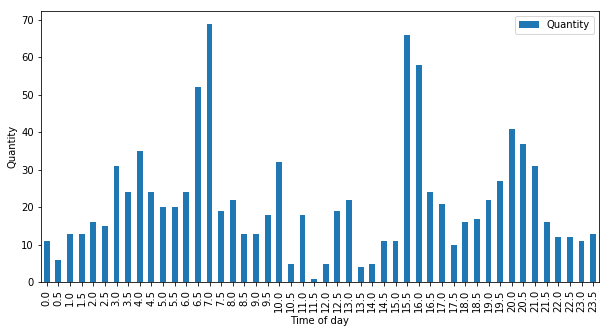

In [10]:
Volumn_Plot = Volumn_Data.plot(x='time',y='Quantity',kind='bar',figsize=(10,5))
Volumn_Plot.set_ylabel('Quantity')
Volumn_Plot.set_xlabel('Time of day')

We see two clear peaks in this data and one smaller one. So it seems likely that market traffic does varry significatly with time. We will investigate this more later by look at other items to see wether this traffic is spacific to Mr. As or not. THe next question I wish to adress is does this increased traffic drive up the costs. If so is there a best time of day for me to purchas (or sell) items in Kol?

In [11]:
Price_Data = Mr_A_Data.iloc[:,2:]

In [12]:
Price_Data['Total Cost']=Price_Data['Quantity']*Price_Data['Cost']
Price_Data=Price_Data.iloc[:,[0,1,3]]
Price_Data = Price_Data.groupby('time').sum()
Price_Data['Mean Cost']=Price_Data['Total Cost']/Price_Data['Quantity']
Price_Data['Time']=Price_Data.index
Price_Data=Price_Data.iloc[:,2:]
Price_Data['Mean Cost']=Price_Data['Mean Cost']-min(Price_Data['Mean Cost'])

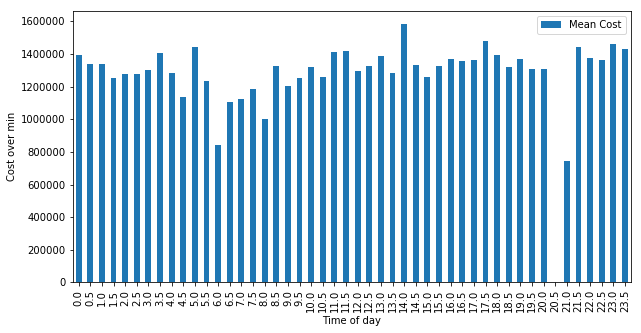

In [13]:
Price_Plot = Price_Data.plot(x='Time',y='Mean Cost',kind='bar',figsize=(10,5))
Price_Plot.set_ylabel('Cost over min')
Price_Plot.set_xlabel('Time of day')

This Graph looks fairly flat so it seems likely that the time of day does not matter. Now let us look at a plot of the amount of Mr. As bout at diffrent prices. Perhaps there is something going on at around 8:30 pm, but I will need to look at more data to be sure. This will help the wise investor know what is a good price to but at and what is a good price to sell at and how often one should expect to find these deals.

In [14]:
Price_Freq = Mr_A_Data.iloc[:,3:]
Price_Freq['Cost']=Price_Freq['Cost'].apply(lambda x: math.floor(x/100000))
Price_Freq=Price_Freq.groupby('Cost').sum()
Price_Freq['Cost']=Price_Freq.index

In [15]:
Price_Freq.head(20)

,Quantity,Cost
Cost,,
240.0,3,240.0
250.0,34,250.0
260.0,4,260.0
264.0,7,264.0
265.0,9,265.0
266.0,13,266.0
267.0,19,267.0
268.0,72,268.0
269.0,60,269.0


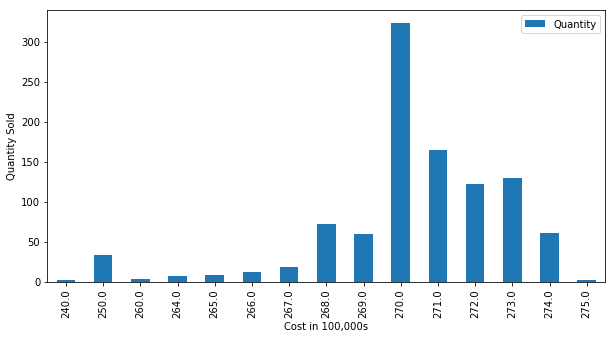

In [16]:
Price_Freq_Plot = Price_Freq.plot(x='Cost',y='Quantity',kind='bar',figsize=(10,5))
Price_Freq_Plot.set_ylabel('Quantity Sold')
Price_Freq_Plot.set_xlabel('Cost in 100,000s')

This seems to follow a left skewed gaussian distribution of some kind. The small peak at 25000000 is of intrest. It could be an outlier however it seems equally possibble that it is people in need of quick cash trying to sell items fast. It could also correspond to a price dip during a certin period of the month (a topic we will look at in the next section). This warrents futhur investigation. I will keep this in mind when I construct similiar plots for other itemss.

# Monthly Price tends
We will get back to these questions latter after we have imported data on diffrent items. for now let us continue workign with tthte Mr. A data. People Tend to be procrastinators. Investors in Kol have long know how to take advantage of this fact. The item of the mounth (the thing mr. As) are used to purchase changes at the end of every month. Thus the price of mr. As tends to increase near the end of the month as people rush to get the items of the month in before Mr. Store stops selling it. In this secttion I would like to try to find when is the best time to buy and sell Mr. As with respect to this montthly cycle. For this section we will use a diffrent data set. It has all the data from the past year but the data is stored by the day and not the half hour so it would not be useful in answering the hourly question.

In [26]:
path = os.path.join(os.getcwd(),'Mr_A_Year')
Convert_Kol(path,'CSV_Mr_A_Year')
path = os.path.join(os.getcwd(),'CSV_Mr_A_Year.csv')
Mr_A_Data_Year=pd.read_csv(path)
Day_of_Month_Data = Mr_A_Data_Year.loc[:,['Month','Day','Quantity','Cost']]
Day_of_Month_Data=Day_of_Month_Data[Day_of_Month_Data['Month']!='Jun']
Day_of_Month_Data['Total Cost']=Day_of_Month_Data['Cost']*Day_of_Month_Data['Quantity']
Day_of_Month_Data=Day_of_Month_Data.groupby(['Month','Day']).sum()
Day_of_Month_Data['Cost'] = Day_of_Month_Data['Total Cost']/Day_of_Month_Data['Quantity']
Day_of_Month_Data.head()

Quantity          Cost    Total Cost
Month Day                                      
Apr   1          91  2.788960e+07  2.537954e+09
      2          43  2.812491e+07  1.209371e+09
      3          37  2.822159e+07  1.044199e+09
      4          71  2.828683e+07  2.008365e+09
      5          83  2.829281e+07  2.348303e+09

Mr. A Prices can vary from month to month depending on how good the unique item of the month is as seen in the following table.

In [29]:
Monthly_Mean=Day_of_Month_Data.loc[:,['Quantity','Total Cost']]
Monthly_Mean=Monthly_Mean.groupby(level=0).sum()
Monthly_Mean['Mean Cost']=Monthly_Mean['Total Cost']/Monthly_Mean['Quantity']
del Monthly_Mean['Total Cost']
del Monthly_Mean['Quantity']
Monthly_Mean

,Mean Cost
Month,
Apr,2.738603e+07
Aug,2.896892e+07
Dec,2.926327e+07
Feb,2.665823e+07
Jan,2.820967e+07
Jul,2.898261e+07
Mar,2.571004e+07
May,2.714638e+07
Nov,3.029205e+07


This leads me to conjecture that the march item of the month (the 'unpowered Robortender') was not very popular. You will note the june is absent. I have removed it since the data downnloaded was for exactly the last year so the data for the month of june was split between this June and June a year ago. Now lets look at some plots for pricing with respect to day of the month.

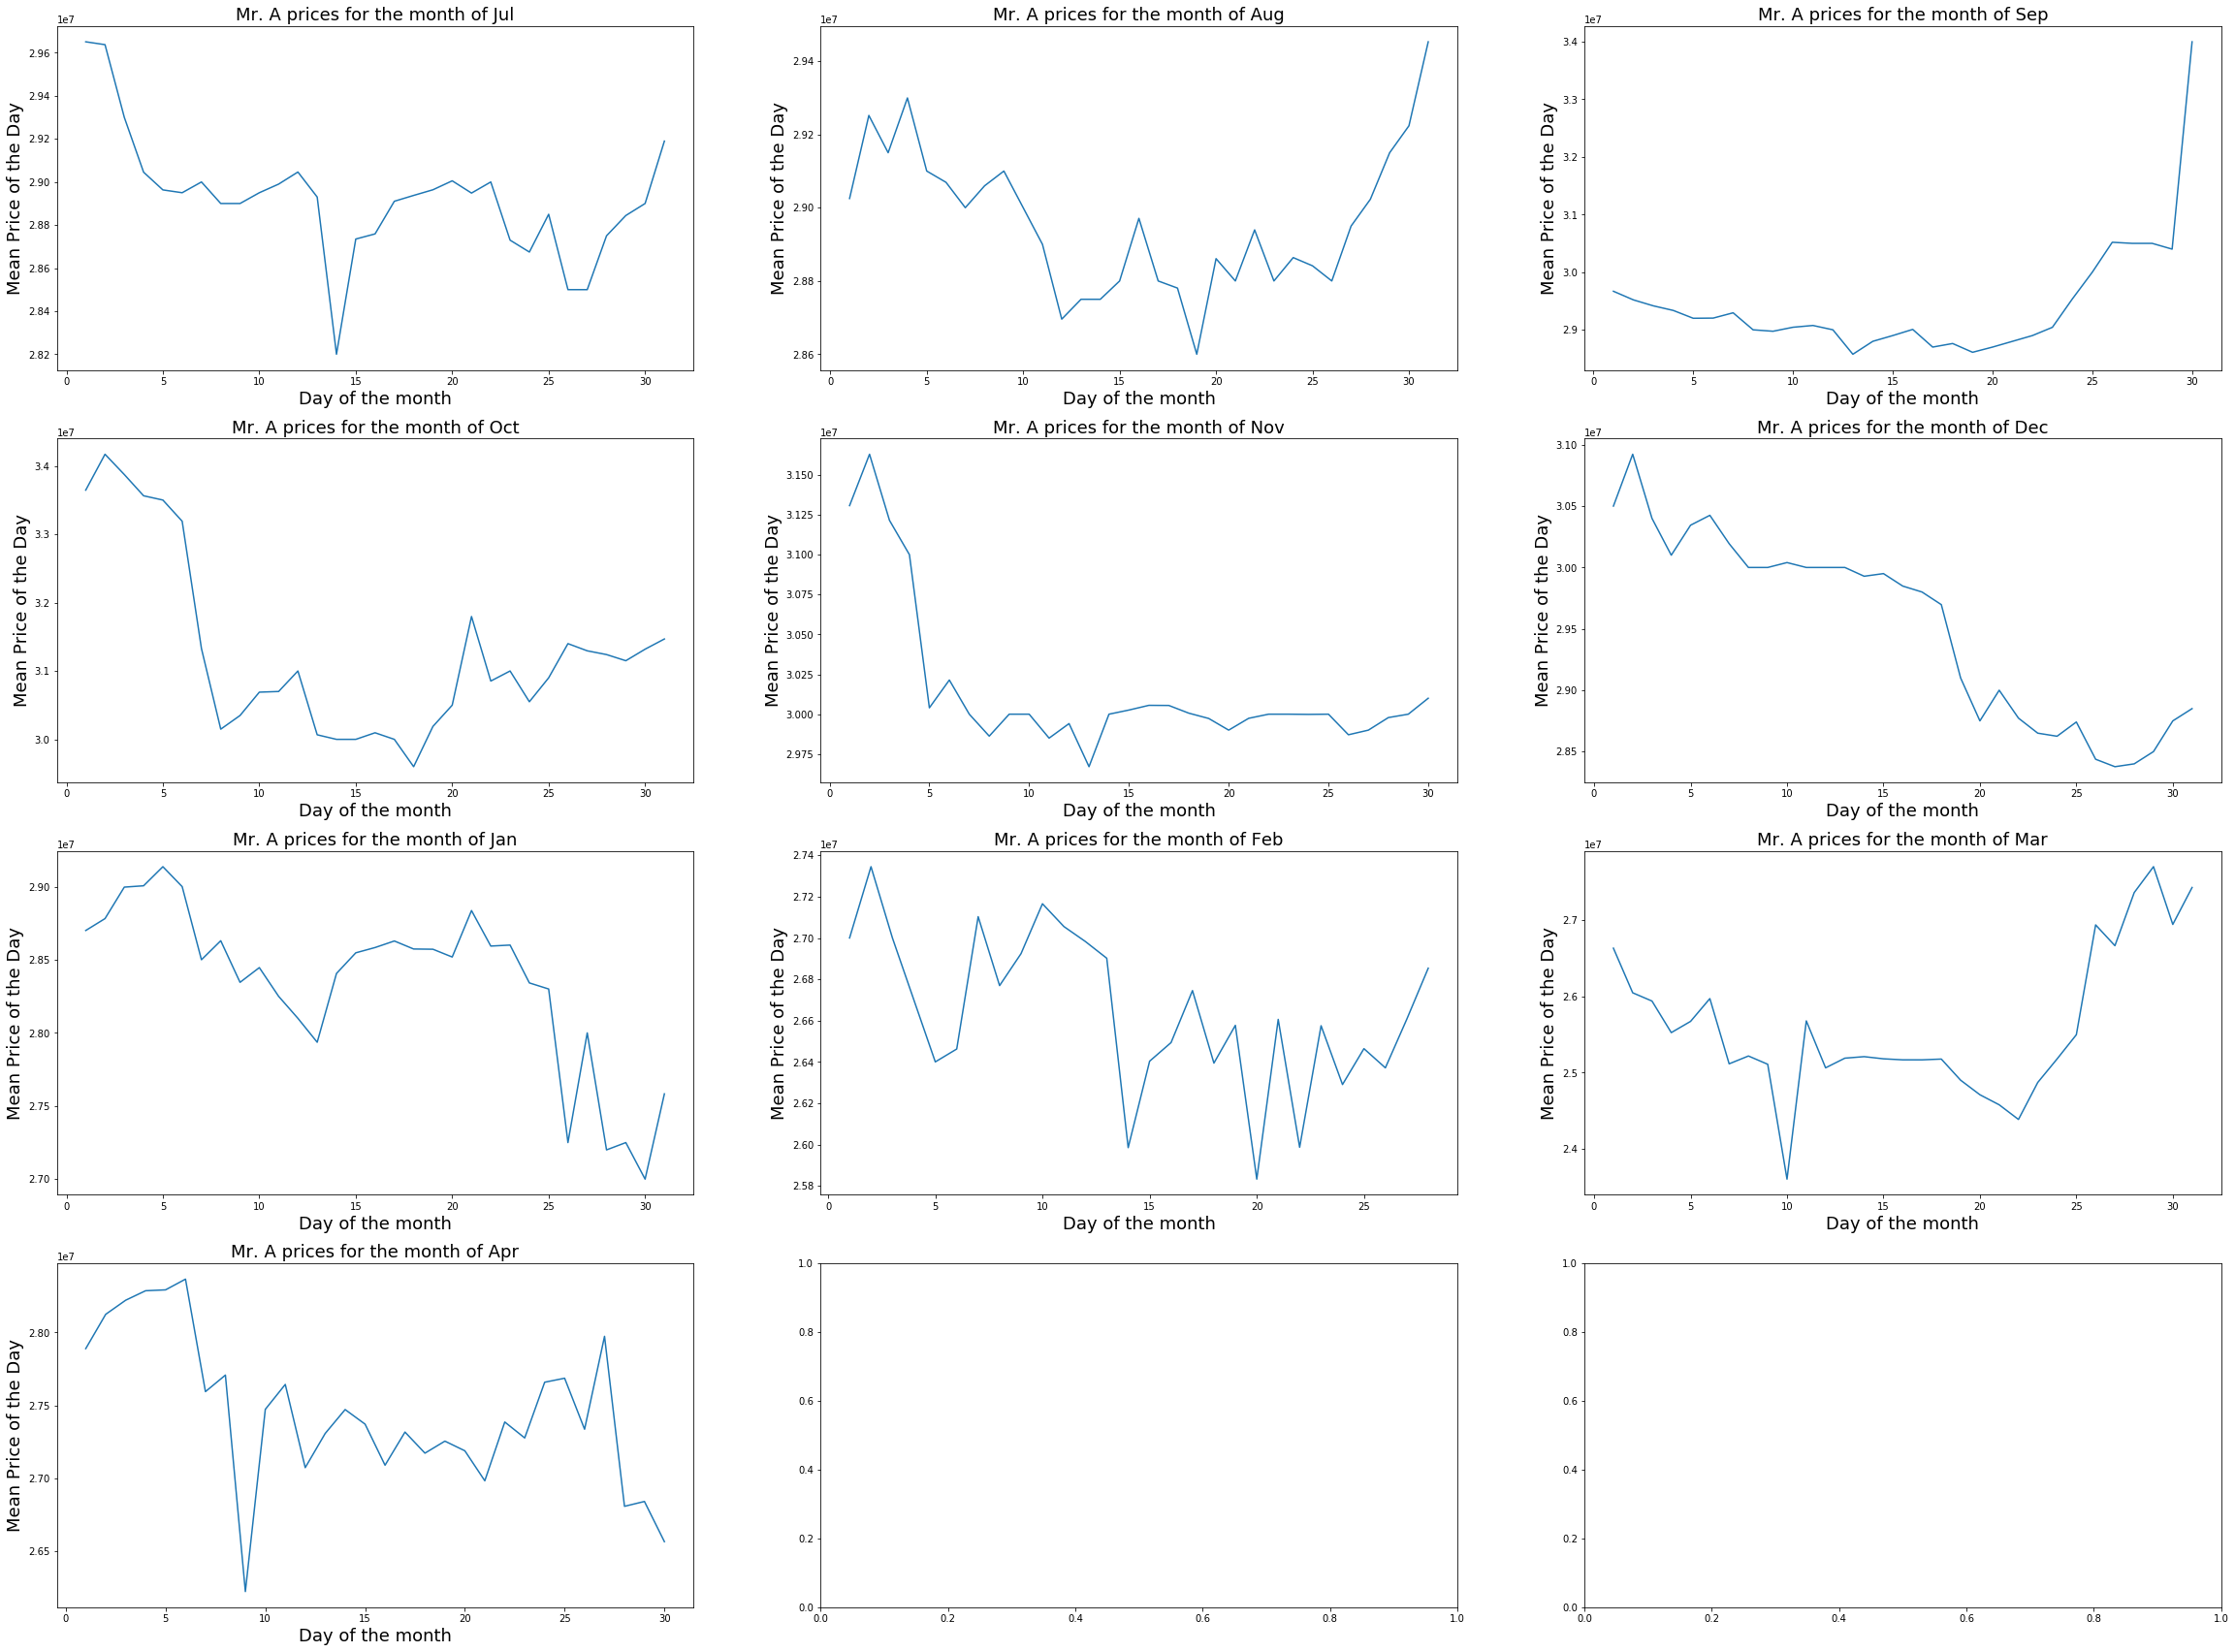

In [78]:
Months = ['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr']# The websit is missing half the data for the month of may
f, a = plt.subplots(4,3)
f.set_size_inches(40,30)
for i in range(0,10):
    temp_Data=Day_of_Month_Data[Day_of_Month_Data.index.get_level_values(0)==Months[i]]
    a[int(math.floor(i/3)),int(i%3)].plot(np.array(temp_Data.index.get_level_values(1)),np.array(temp_Data['Cost']))
    a[int(math.floor(i/3)),int(i%3)].set_xlabel('Day of the month', fontsize=18)
    a[int(math.floor(i/3)),int(i%3)].set_ylabel('Mean Price of the Day', fontsize=18)
    a[int(math.floor(i/3)),int(i%3)].set_title('Mr. A prices for the month of '+Months[i], fontsize=18)

So it would seem I have human nature wrong. It seems that perhaps I have projected my own flaws on to humanity in general (I have so few of them that this has never happened before). People are not procrastinators, they are in fact early birds!!! Some times there is a spike in cost near the end of the month I sugested but farm more often (always in fact) there is a spike in cost at the begining of the month as people rush in to get their shiny (in the firefly sense of the word not the reflectivity sense) new item.

# Simple Predictions
Now lets try to make some predictions. I notice several trends in how the data behaves at the end of the month, but due to the limited size of out set lets keep it simple, either the price goes up at the end of the month or it does not. Very roughly I woluld say this tends to happen around the 20th day of the month. So I would like to classify wether or not this price increase will happen based on the data from the first 20 days. This information would be very useful for directing my investiments. For one if the price decreases clearly I should wait to buy then, but even if the price stays constant the latter I need to commit my meat the better as it means I can keep it invested in other things. Before over thinking a problem it is best to try the simpliest possible thing that has a chance att working. So I will sttart with using a nearest neighbor classification with each month corresponding to a data point and each day being a dimension. First however I will need to get the data in the required form and normalize it else the nearist neighbor apporch may simply end up detectting months with similiar mean cost.

In [114]:
X=[]
Y=[1,1,1,0,0,0,0,1,1,0]
for month in Months:
    X.append((np.array(Day_of_Month_Data[Day_of_Month_Data.index.get_level_values(0)==month]['Cost'][0:20])/Monthly_Mean.at[month,'Mean Cost']).tolist())

Normally one would select a cross validation set randomly but due to the small size of our data we need to be careful as a randomly selected cross validation set could very easily be of entirely one classification and thtus not be representative of the data. Thus I will take me cross validation set to be the months of November, March and Febuary.

In [115]:
train_index = [0,1,2,3,5,6,9] 
cv_index = [4,7,8]
X_train = []
Y_train = []
X_cv = []
Y_cv = []
for i in train_index:
    X_train.append(X[i])
    Y_train.append(Y[i])
for i in cv_index:
    X_cv.append(X[i])
    Y_cv.append(Y[i])

I stop at looking at the four nearest neighbors for now since it does not make sence to look at larger values because there may not even be more then four datra points of a certin class.

In [95]:
print('Accuarray for 1 nearest neighbor')
print(KNeighborsClassifier(n_neighbors=1).fit(X_train,Y_train).score(X_cv,Y_cv))
print('Accuarray for 2 nearest neighbor')
print(KNeighborsClassifier(n_neighbors=2).fit(X_train,Y_train).score(X_cv,Y_cv))
print('Accuarray for 3 nearest neighbor')
print(KNeighborsClassifier(n_neighbors=3).fit(X_train,Y_train).score(X_cv,Y_cv))
print('Accuarray for 4 nearest neighbor')
print(KNeighborsClassifier(n_neighbors=4).fit(X_train,Y_train).score(X_cv,Y_cv))

Accuarray for 1 nearest neighbor
0.666666666667
Accuarray for 2 nearest neighbor
0.666666666667
Accuarray for 3 nearest neighbor
0.666666666667
Accuarray for 4 nearest neighbor
0.666666666667


All and all not a great result (perhaps not even better then random guessing but it is hard to tell with such a small cross validation set) but not very suprizing given the limited data. I want to try one more thing before I go out on a quest to seek more data. When we normalized the data inn essence lost some information, the mean costt. It seems very possible that how good an item is (reflected in the mean cost) effect people purchesing habits. Obviously we cant use an unnormalized cost since itt would clearly dominate distance compared to the otther values which are all close to one. So we will normalized it the yearly mean.

In [117]:
Yearly_Mean = Day_of_Month_Data['Total Cost'].sum()/Day_of_Month_Data['Quantity'].sum()
for weight in range(1,22,5):
    X_temp = X
    for i in range(0,len(X)):
        X_temp[i].append(weight*Monthly_Mean.at[Months[i],'Mean Cost']/Yearly_Mean)
    X_temp_train = []
    X_temp_cv = []
    for i in train_index:
        X_temp_train.append(X[i])
    for i in cv_index:
        X_temp_cv.append(X[i])
    print('Accuarray for weight ' +str(weight))
    print(KNeighborsClassifier(n_neighbors=3).fit(X_temp_train,Y_train).score(X_temp_cv,Y_cv))

Accuarray for weight 1
0.333333333333
Accuarray for weight 6
0.333333333333
Accuarray for weight 11
0.333333333333
Accuarray for weight 16
0.333333333333
Accuarray for weight 21
0.333333333333


So no imporovement. In fact it got worse. At the conclusionn I managed to ascend the labrinth with twice the data however.

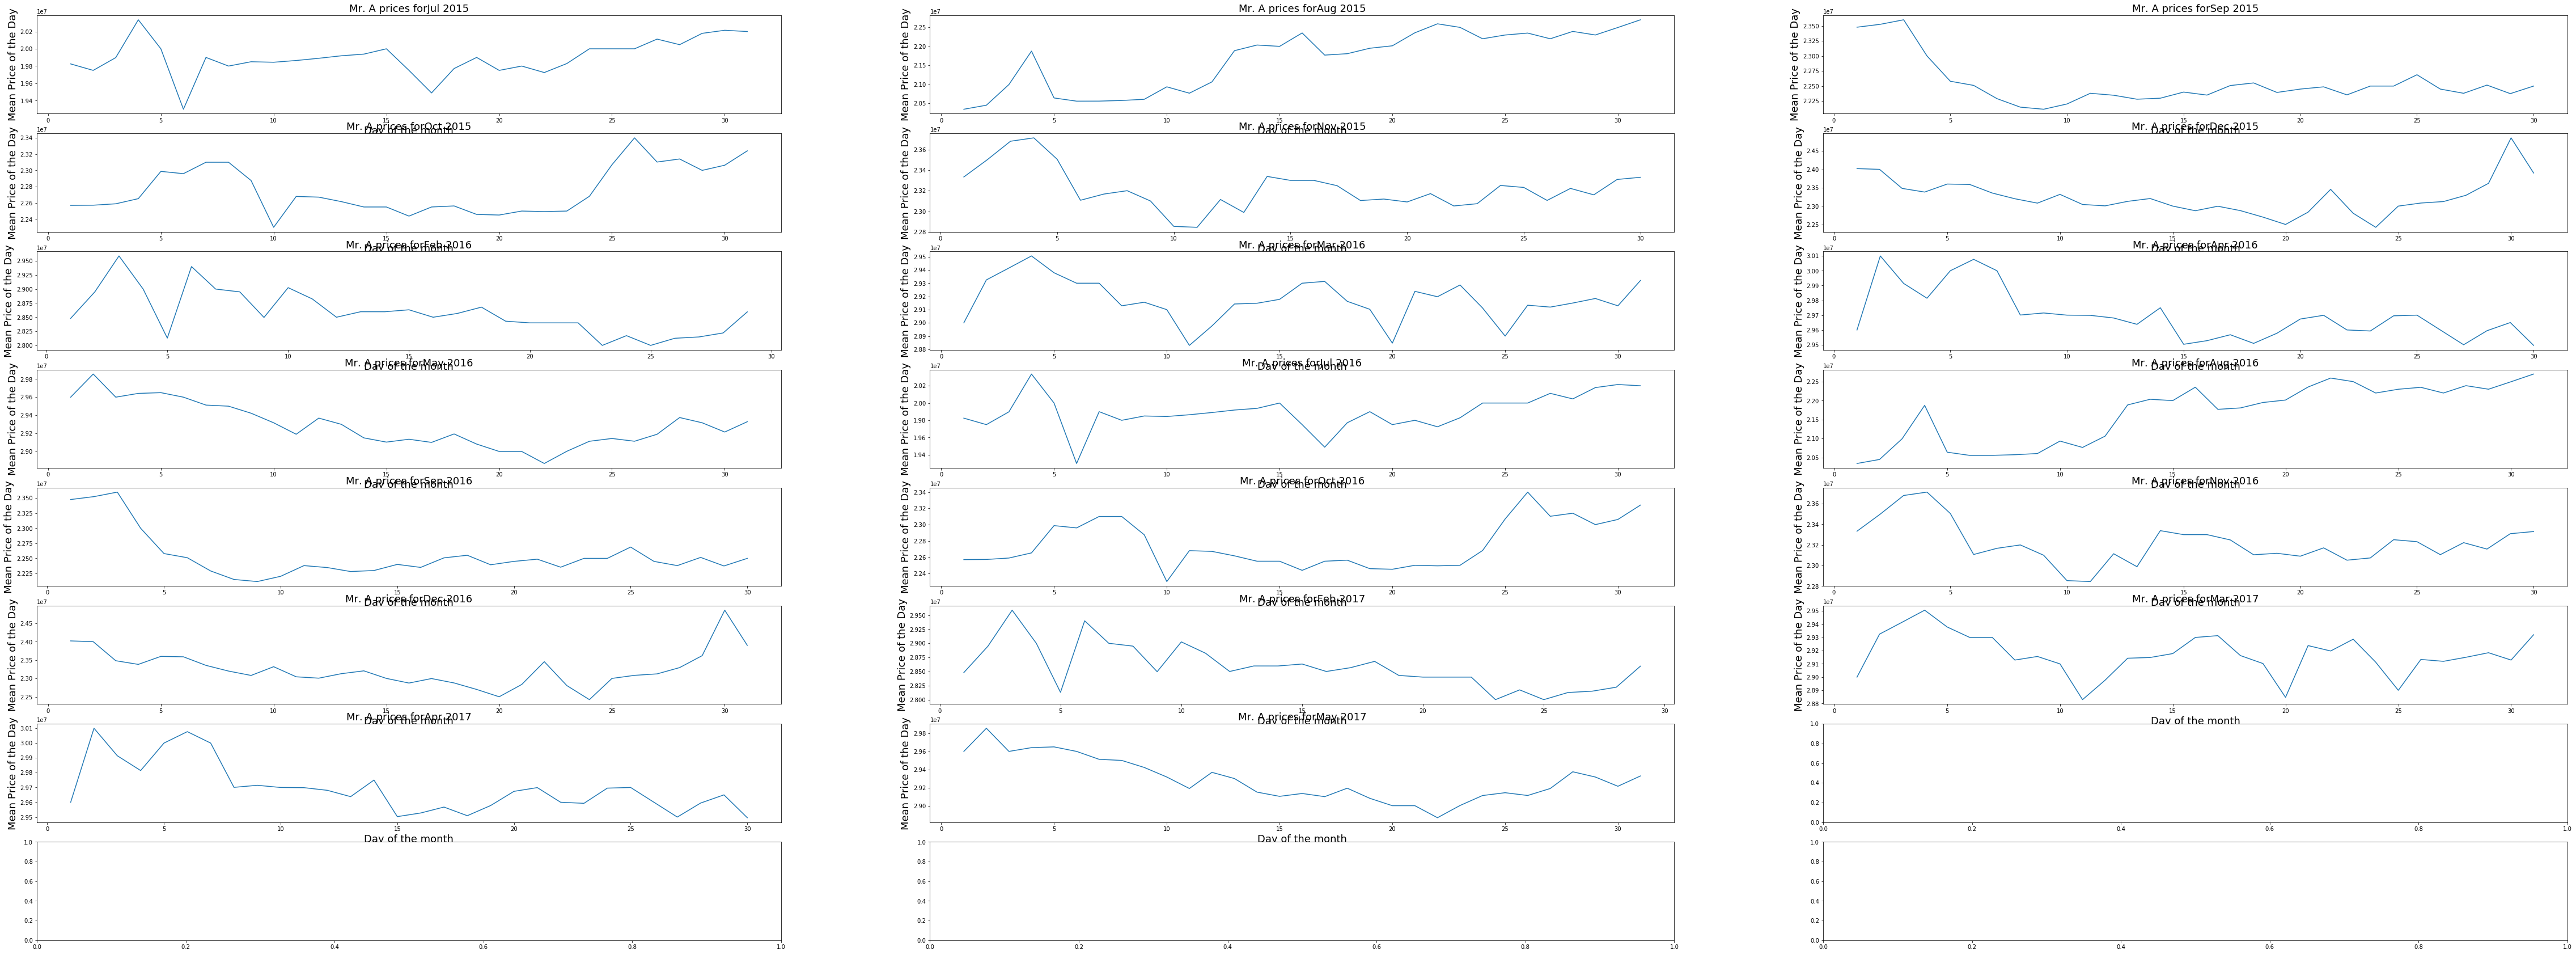

In [27]:
path = os.path.join(os.getcwd(),'Mr_A_2015_2016')
Convert_Kol(path,'Mr_A_2015_2016')
path = os.path.join(os.getcwd(),'Mr_A_2015_2016.csv')
Mr_A_Data1 = pd.read_csv(path)
path = os.path.join(os.getcwd(),'Mr_A_2015_2016')
Convert_Kol(path,'Mr_A_2015_2016')
path = os.path.join(os.getcwd(),'Mr_A_2015_2016.csv')
Mr_A_Data2 = pd.read_csv(path)
Mr_A_Data = pd.concat([Mr_A_Data1,Mr_A_Data2])
Mr_A_Data['Year']=[0]*len(Mr_A_Data.index)
year = 2015
for i in range(0,len(Mr_A_Data.index)):
    Mr_A_Data.iat[i,5]=year
    if Mr_A_Data.iat[i,0]=='Jan' and Mr_A_Data.iat[i-1,0]=='Dec':
        year = year+1
del Mr_A_Data['time']
Mr_A_Data['Cost'] = Mr_A_Data['Cost']*Mr_A_Data['Quantity']
Mr_A_Data = Mr_A_Data.groupby(['Year','Month','Day']).sum()
Mr_A_Data['Cost']=Mr_A_Data['Cost']/Mr_A_Data['Quantity']
f, a = plt.subplots(8,3)
f.set_size_inches(80,30)
Months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
Years =[2015,2016,2017]
k=0
X=[]
for j in range(0,3):
    temp = Mr_A_Data[Mr_A_Data.index.get_level_values(0)==Years[j]]
    for i in range(0,12):
        temp2 = temp[temp.index.get_level_values(1)==Months[i]]
        if len(temp2.index)>27:#Remove months with partial data
            mean = temp2['Cost'].sum()/temp2['Quantity'].sum()
            X.append((np.array(temp2['Cost'][0:20])/mean).tolist())
            a[int(math.floor(k/3)),int(k%3)].plot(np.array(temp2.index.get_level_values(2)),np.array(temp2['Cost']))
            a[int(math.floor(k/3)),int(k%3)].set_xlabel('Day of the month', fontsize=18)
            a[int(math.floor(k/3)),int(k%3)].set_ylabel('Mean Price of the Day', fontsize=18)
            a[int(math.floor(k/3)),int(k%3)].set_title('Mr. A prices for'+Months[i]+' '+str(Years[j]), fontsize=18)
            k = k+1

In [36]:
Y=[1,1,0,1,0,1,0,1,0,1,1,1,0,1,1,1,0,1,0,1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
for i in range(1,6):
    print 'Score for '+str(i)+'nearest neighbors is:'
    print(KNeighborsClassifier(n_neighbors=i).fit(X_train,Y_train).score(X_test,Y_test))

Score for 1nearest neighbors is:
0.6
Score for 2nearest neighbors is:
0.6
Score for 3nearest neighbors is:
0.6
Score for 4nearest neighbors is:
1.0
Score for 5nearest neighbors is:
0.6


# Long Term Investments
Mr. As can be traded for a unique item of the month that no longer becomes available at the end of the month. Another common investment stratgity if to buy these items and sell them some time latter. Usually on the order of months. However there is a large opertunity cost to this type of investment as it locks up large amounts of meat for a long period of time making it unavailable for other type of investment. So I would now like to look at this type of investment and see how it compares to the stragity presented above.

# Other Items
Mr. Asscessories are fairly expensive items so many of the trends noticed above might not apply to other items. The Produce Graphs function will reproduce the graphs for diffrent items. First we will investigate items the players tend to purchas daily rather then monthly. A key example of this type of item is foods.

# Potion of the field gar

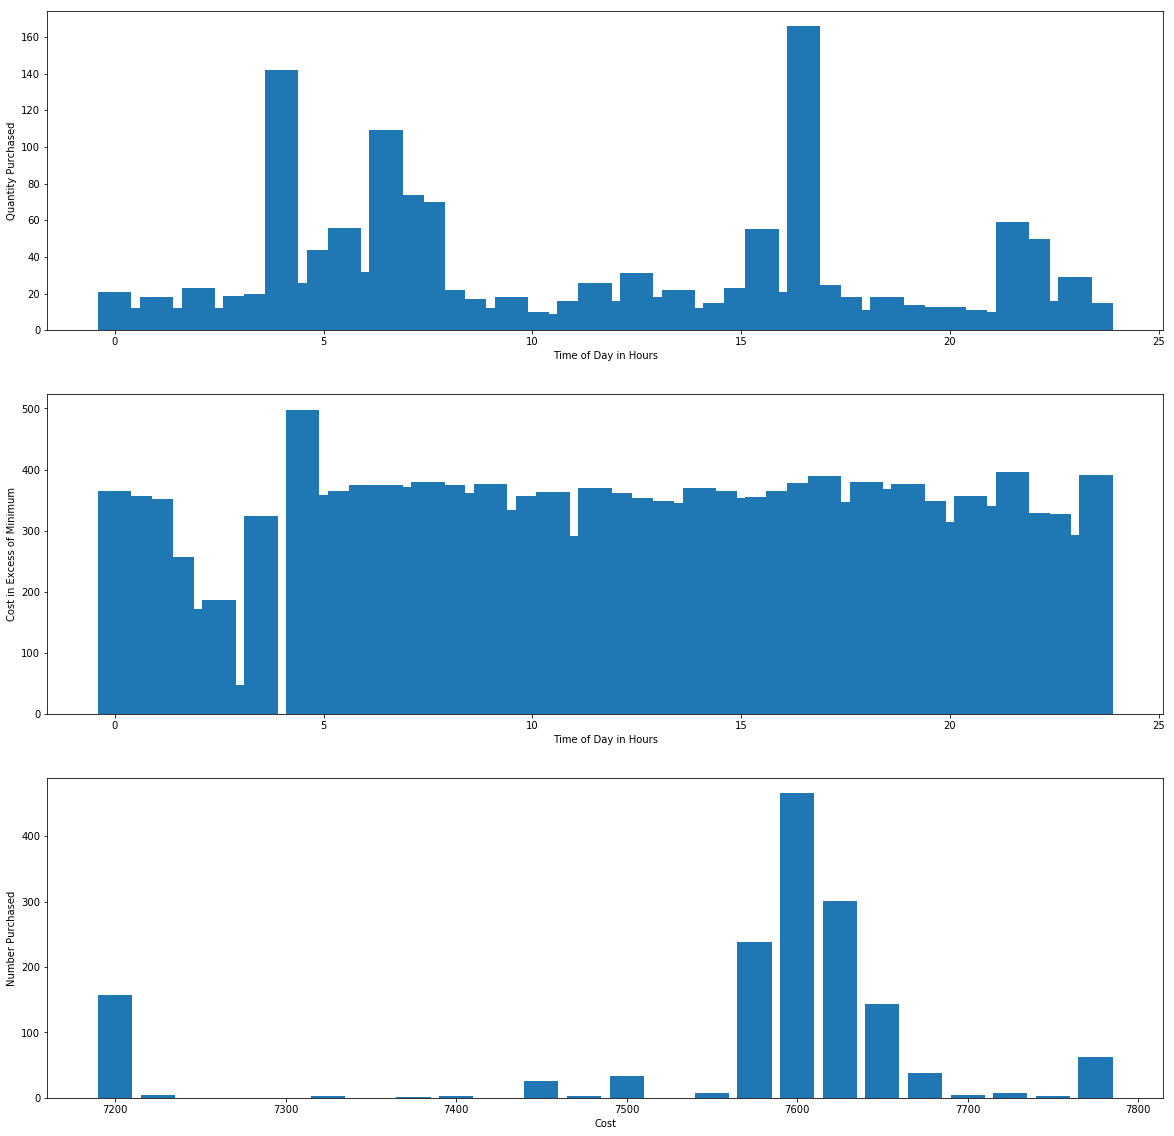

In [2]:
path = os.path.join(os.getcwd(),'Potion_of_the_field_gar')
Convert_Kol(path,'Potion_of_the_field_gar')
data = pd.read_csv(os.path.join(os.getcwd(),'Potion_of_the_field_gar.csv'))
data['Cost']=data['Cost'].apply(lambda x: round(x/25)*25)#many people try to get the cheapest price by undercutting by a
#negligaable amout of mean so we round the data to the nearest 25 meat
Produce_Graphs(data,20)

So here we see dispite the difrence in the nature of the item the graphs appear to be similiar. We still have two peeks in number of purchases with respect to time at around 4 and 16. These likely simply represent that this is when most people play Kol. Again dispite the amoutt of purchases changing with respect to time of day the cost does not. So there does no appear to be a significant advant to purchasing item with respect to any particular time of the day. More over the outlier that occured with mr. As at 8:30 pm seems to have vanished here. Again the graph of number of purchases with respect to cost seems to again be a left skewed normal distribution. The spike on the left seems to have persisted across items, so it is possible that it is behavorially motivated trend and not an outlier as suggested earlier.

In Kol one needs to get white rice inorder to make sushi (cause come on brown rice sushi would be kind of weird). And everybody likes sushi. Why? Because it lets you breather underwater of course. So in the spirit of my recent vacation to japan lets study white rice prices.

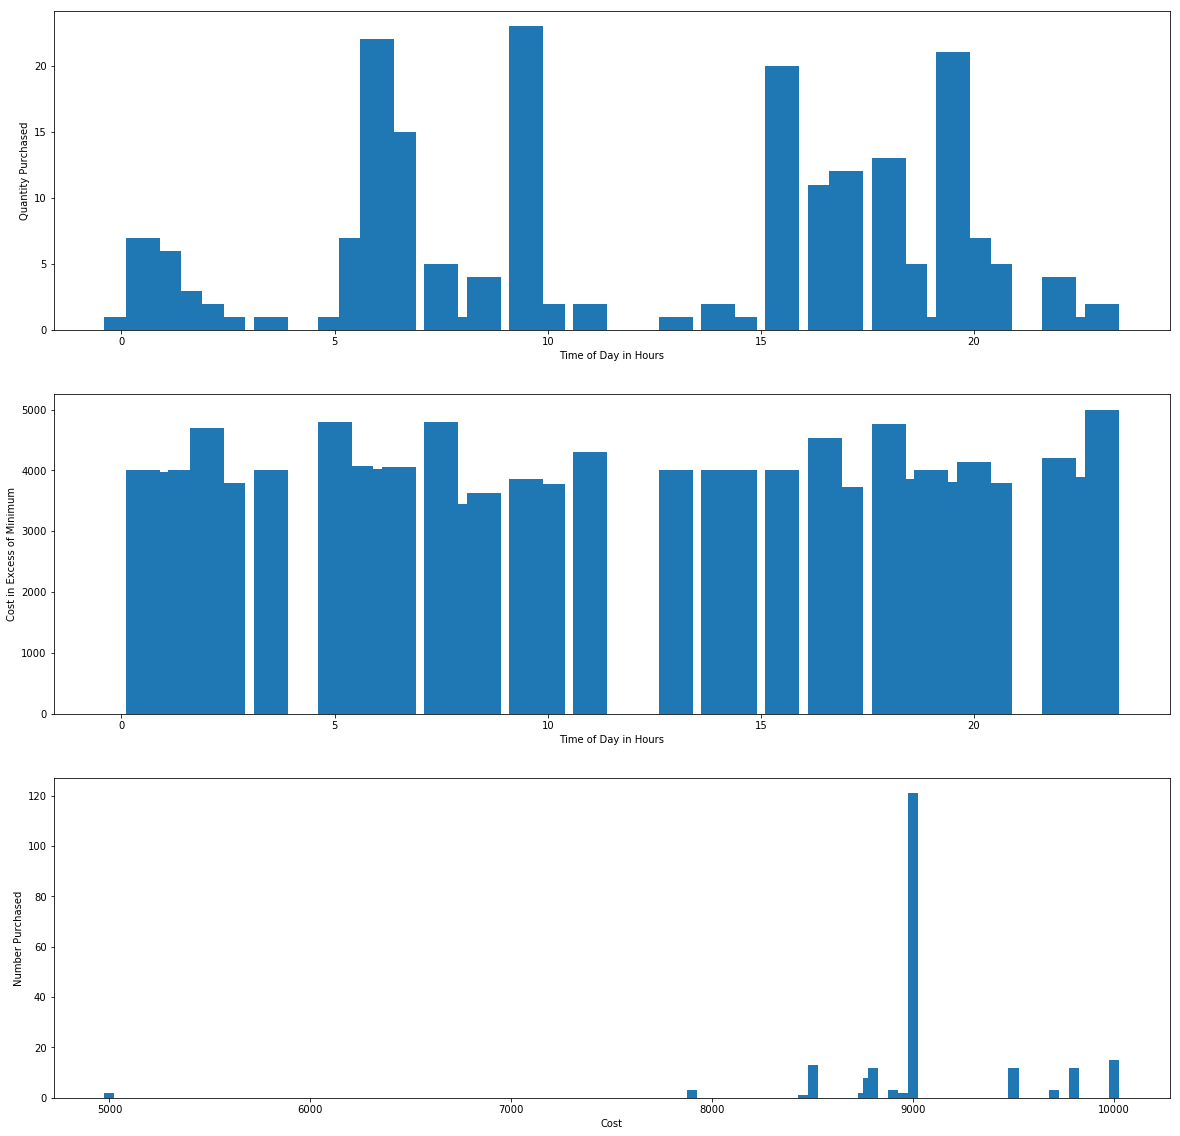

In [11]:
path = os.path.join(os.getcwd(),'white_rice')
Convert_Kol(path,'white_rice')
data = pd.read_csv(os.path.join(os.getcwd(),'white_rice.csv'))
data['Cost']=data['Cost'].apply(lambda x: round(x/25)*25)
Produce_Graphs(data,50)

Now lets look at shots of Kardasian Gin.

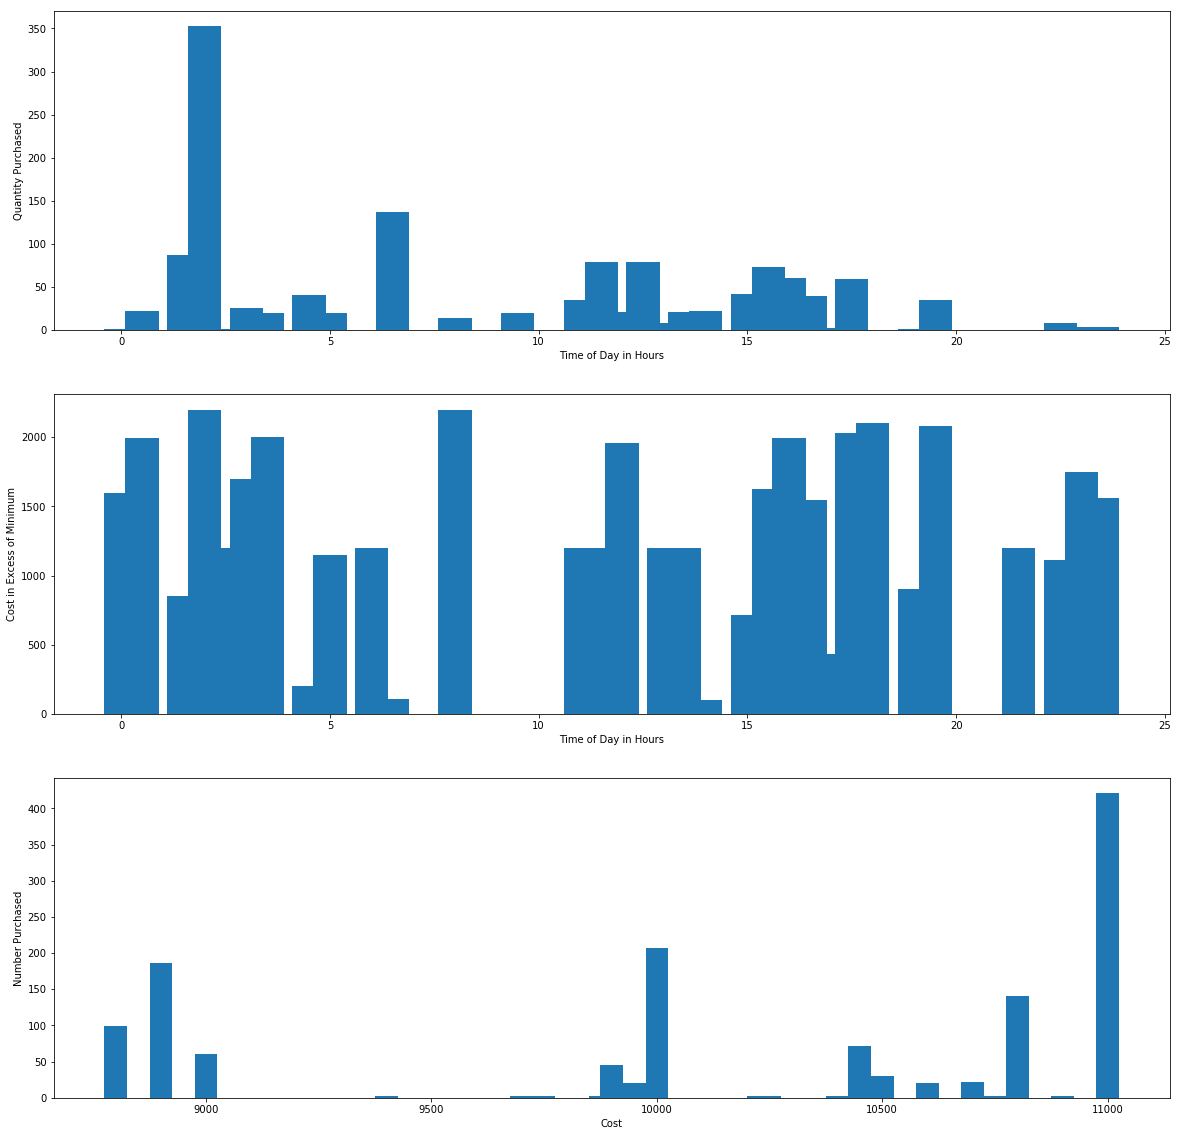

In [4]:
path = os.path.join(os.getcwd(),'Shot_of_Kardashian_Gin')
Convert_Kol(path,'Shot_of_Kardashian_Gin')
data = pd.read_csv(os.path.join(os.getcwd(),'Shot_of_Kardashian_Gin.csv'))
data['Cost']=data['Cost'].apply(lambda x: round(x/25)*25)
Produce_Graphs(data,50)